<a href="https://colab.research.google.com/github/Aragnzlz/SIMULACION-II/blob/main/SIMPY_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SIMULACION DE EVENTOS DISCRETOS CON SIMPY**

La biblioteca SimPy es una biblioteca en Python diseñada para modelar y simular sistemas de eventos discretos.
Se utiliza para simular eventos como:
* líneas de producción
* sistemas de colas
* redes de transporte
entre otros.

**CONCEPTOS CLAVE**

1. **Eventos discretos:**  el tiempo en el modelo avanza de un evento al siguiente, en lugar de ser continuo.
2. **Procesos:** cualquier acción que ocurre en el sistema simulado, se puede indentificar un proceso dentro del programa con la palabra yield.
3. **Recursos:** existen diferentes tipos de recursos.
    *   Resourse: recurso genérico
    *   Container: recurso con una cantidad específica de objetos.
    *   Store: permite almacenar objetos.
    *   PriorityResourse: se asigna prioridades a los procesos.
4. **Entorno(Enviroment):** es el núcleo de una simulación de SimPy y gestiona el tiempo simulado y todos los eventos.
5. **Eventos:** son los puntos de acción en la simulación. Cada proceso espera un evento o desencadena uno que afectará al sistema.


# **EXPLICACION DEL PROBLEMA**
Uno de los principales medios de transporte de la Ciudad de México es el metrobúes, el cual se divide por 7 lineas. Siendo la linea 1 la de mayor afluencia, esto por su conectividad a diferentes rutas de trasnporte que llegan desde el Estado de México, a través de la estación de Indios Verdes.

En este programa utilizaremos la libreria Simpy para modelar la afluencia de pasajeros en horas pico.

1. Instalamos la libreria Simpy

In [89]:
!pip install simpy

In [116]:
import simpy
import random
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np

2. Inicializamos los arreglos que utilizaremos a lo largo de la simulación, estos alacenaran los diferentes tiempos de llegada y partida, tanto de pasajeros como de autobuses.

In [94]:
tiempos_llegada_pasajeros = []
tiempos_abordaje_metrobuses = []
tiempos_partida_metrobuses = []
tiempos_llegada_autobuses = []
tiempos_partida_autobuses = []
tiempos_espera_pasajeros = []
tiempo_partida = []
pasajeros_abordo = []
aut = [] # de autobus
n_p = [] #número de pasajero

3. Definimos los parámetros de la simulación:
* **TASA_LLEGADA_PASAJEROS = 0.06**, establecemos la llegada de pasajeros cada 0.6 segundos, esto después de realizar varias pruebas y tomar el que más se aproxime a la alfuencia diaria.

* **CAPACIDAD_METROBUS = 240** , la capacidad del metrobús es de 240 pasajeros, de los cuales 49 pueden ir sentados y 191 parados.

* **TIEMPO_ABORDAJE_GRUPO = 2 / 60**      
* **TAMANO_GRUPO_ABORDAJE = 8**            

El metrobús cuenta con 2 vagones, de los cuales cada uno tiene dos puertas, supongamos que cada dos segundo en cada una de las puertas entran 2 personas. Es por ellos, que se define que un grupo de 8 personas entra al metrobús cada 2 segundos.

* **TIEMPO_ESPERA_METROBUS = 0.5**

* **TIEMPO_SIMULACION = 120**

Simularemos unicamente dos horas.

In [96]:
TASA_LLEGADA_PASAJEROS = 0.06       # En promedio, llegan 2 pasajeros cada 0.6 segundos
INTERVALO_LLEGADA_METROBUS = 5      # Un Metrobús cada 5 minutos
CAPACIDAD_METROBUS = 240            # Capacidad del Metrobús
TIEMPO_ABORDAJE_GRUPO = 2 / 60      # 2 segundos en minutos para abordar 8 personas
TAMANO_GRUPO_ABORDAJE = 8           # Tamaño del grupo que aborda a la vez
TIEMPO_ESPERA_METROBUS = 0.5        # 1/2 minuto de espera en la estación
TIEMPO_SIMULACION = 120             # Simulación de 2 horas

La función siguiente define un proceso llamado llegada de pasajeros, que como su nombre dice, modela la llegada de pasajeros al metrobús.

* **env:** controla el tiempo y permite pausar el proceso para esperar ciertos eventos.
* **pasajero_id**: es un contador que se incrementa con cada nuevo pasajero.
* **yield env.timeout(...):** usa una distribución exponencial para modelar el tiempo de espera entre la llegada de cada pasajero.
* **Añadir a la cola:** el pasajero se agrega a la lista pasajeros, representando que el pasajero ahora está esperando en la estación.

In [132]:
def llegada_pasajeros(env, pasajeros,tiempos_llegada,n_p):
    pasajero_id = 0
    while True:
        # Tiempo hasta la llegada de un nuevo pasajero
        yield env.timeout(random.expovariate(1 / TASA_LLEGADA_PASAJEROS))
        pasajero_id += 1
        print(f"* Pasajero {pasajero_id} llega a la estación en el minuto {env.now:.2f}")
        # Añadir el pasajero a la cola de espera
        pasajeros.append(pasajero_id)
        tiempos_llegada_pasajeros.append(env.now)
        n_p.append(pasajero_id)

La función siguiente define un proceso llamado llegada de metrobús, que como su nombre dice, modela la llegada de los metrobuses.

* **autobús_id:** Se inicia en 0 y se incrementa cada vez que llega un nuevo Metrobús.
* **yield env.timeout(INTERVALO_LLEGADA_METROBUS):** el proceso de llegada de un Metrobús se detendrá durante un intervalo de tiempo especificado por INTERVALO_LLEGADA_METROBUS.
*  **yield env.timeout(TIEMPO_ABORDAJE_GRUPO): ** simula el tiempo necesario para que el grupos de 8 personas aborde el autobús.

In [133]:
def llegada_metrobús(env, pasajeros, aut,tiempos_llegada_autobuses,tiempos_partida_metrobuses,pasajeros_abordo,tiempo_partida):
    autobús_id = 0
    while True:
        # Tiempo hasta la llegada de un nuevo Metrobús
        yield env.timeout(INTERVALO_LLEGADA_METROBUS)
        autobús_id += 1
        print(f"\n ---> Metrobús {autobús_id} llega a la estación en el minuto {env.now:.2f}<--- ")
        aut.append(autobús_id)
        tiempos_llegada_autobuses.append(env.now)

        # Tiempo que el Metrobús espera en la estación para abordar pasajeros
        tiempo_final_abordaje = env.now + TIEMPO_ESPERA_METROBUS
        pasajeros_a_bordo = 0

        # Aborda en grupos de hasta 8 personas cada 2 segundos mientras dure el tiempo de espera
        while env.now < tiempo_final_abordaje and pasajeros and pasajeros_a_bordo < CAPACIDAD_METROBUS:
            grupo_abordo = min(len(pasajeros), TAMANO_GRUPO_ABORDAJE, CAPACIDAD_METROBUS - pasajeros_a_bordo)

            # Cada grupo tarda 2 segundos en abordar
            yield env.timeout(TIEMPO_ABORDAJE_GRUPO)

            # Remover el grupo de pasajeros que abordaron y contar
            for _ in range(grupo_abordo):
                tiempo_partida.append(env.now)
                pasajeros.pop(0)

            pasajeros_a_bordo += grupo_abordo
            print(f"{grupo_abordo} pasajeros abordan el Metrobús {autobús_id} en el minuto {env.now:.2f}")

            # Partida del Metrobús
        print(f"---> El Metrobús {autobús_id} parte con {pasajeros_a_bordo} pasajeros en el minuto {env.now:.2f}<---")
        tiempos_partida_metrobuses.append(env.now)
        pasajeros_abordo.append(pasajeros_a_bordo)


Para utilizar la libreria Simpy debemos:

**1. Confurar el entorno:** inicializamos el entorno de la simulación, el cual se encarga de la ejecución de los procesos.

**2. Inicializamos lo procesos**

**3. Ejecución de la simualción**

In [134]:
# Configurar el entorno de SimPy
env = simpy.Environment()
pasajeros = []  # Lista para contar los pasajeros en espera
tiempos_llegada_pasajeros = []
aut = []
tiempos_llegada_autobuses = []
tiempos_partida_metrobuses = []
pasajeros_abordo = []
tiempos_espera_pasajeros=[]
n_p = []
tiempo_partida = []

In [135]:
# Inicializar los procesos
env.process(llegada_pasajeros(env, pasajeros, tiempos_llegada_pasajeros,n_p))
env.process(llegada_metrobús(env, pasajeros,aut,tiempos_llegada_autobuses,tiempos_partida_metrobuses,pasajeros_abordo,tiempo_partida))

<Process(llegada_metrobús) object at 0x78aea325fe50>

In [136]:
# Ejecutar la simulación
env.run(until=TIEMPO_SIMULACION)

* Pasajero 1 llega a la estación en el minuto 0.11
* Pasajero 2 llega a la estación en el minuto 0.38
* Pasajero 3 llega a la estación en el minuto 0.50
* Pasajero 4 llega a la estación en el minuto 0.53
* Pasajero 5 llega a la estación en el minuto 0.53
* Pasajero 6 llega a la estación en el minuto 0.55
* Pasajero 7 llega a la estación en el minuto 0.57
* Pasajero 8 llega a la estación en el minuto 0.62
* Pasajero 9 llega a la estación en el minuto 0.72
* Pasajero 10 llega a la estación en el minuto 0.73
* Pasajero 11 llega a la estación en el minuto 0.79
* Pasajero 12 llega a la estación en el minuto 0.80
* Pasajero 13 llega a la estación en el minuto 0.83
* Pasajero 14 llega a la estación en el minuto 0.90
* Pasajero 15 llega a la estación en el minuto 0.95
* Pasajero 16 llega a la estación en el minuto 1.11
* Pasajero 17 llega a la estación en el minuto 1.15
* Pasajero 18 llega a la estación en el minuto 1.20
* Pasajero 19 llega a la estación en el minuto 1.23
* Pasajero 20 llega a

Para calcular los tiempos de espera utilizamos la libreria numpy para restar los tiempos de llegada y partida de cada pasajero.

In [137]:
a = np.array(tiempos_llegada_pasajeros)
b = np.array(tiempo_partida)
min_len = min(len(a), len(b))
a = a[:min_len]
b = b[:min_len]
tiempo_espera = [y - x for x, y in zip(a, b)]

Imprimimos el tiempo de llegada, partida y espera de cada pasajero en una tabla.

In [138]:
min_len = min(len(n_p), len(tiempos_llegada_pasajeros), len(tiempo_partida), len(tiempo_espera))
A = [[n_p[i], tiempos_llegada_pasajeros[i], tiempo_partida[i],tiempo_espera[i]] for i in range(min_len)]
head = ["PASAJERO", "T_LLEGADA", "T_PARTIDA","T_ESPERA"]
A.insert(0, head)
from tabulate import tabulate
print(tabulate(A, headers="firstrow", tablefmt="fancy_grid"))

╒════════════╤═════════════╤═════════════╤════════════╕
│   PASAJERO │   T_LLEGADA │   T_PARTIDA │   T_ESPERA │
╞════════════╪═════════════╪═════════════╪════════════╡
│          1 │    0.106766 │     5.03333 │  4.92657   │
├────────────┼─────────────┼─────────────┼────────────┤
│          2 │    0.3797   │     5.03333 │  4.65363   │
├────────────┼─────────────┼─────────────┼────────────┤
│          3 │    0.502298 │     5.03333 │  4.53103   │
├────────────┼─────────────┼─────────────┼────────────┤
│          4 │    0.530128 │     5.03333 │  4.5032    │
├────────────┼─────────────┼─────────────┼────────────┤
│          5 │    0.531616 │     5.03333 │  4.50172   │
├────────────┼─────────────┼─────────────┼────────────┤
│          6 │    0.550145 │     5.03333 │  4.48319   │
├────────────┼─────────────┼─────────────┼────────────┤
│          7 │    0.565364 │     5.03333 │  4.46797   │
├────────────┼─────────────┼─────────────┼────────────┤
│          8 │    0.620779 │     5.03333 │  4.41

El siguiente código registra el tiempo de llegada y partida de cada metrobús así como los pasajeros a bordo con el que parte.

In [139]:
min_len = min(len(aut), len(tiempos_llegada_autobuses), len(tiempos_partida_metrobuses))
A = [[aut[i], tiempos_llegada_autobuses[i], tiempos_partida_metrobuses[i],pasajeros_abordo[i]] for i in range(min_len)]
head = ["METROBÚS", "T_LLEGADA", "T_PARTIDA", "P. ABORDO"]
A.insert(0, head)
from tabulate import tabulate
print(tabulate(A, headers="firstrow", tablefmt="fancy_grid"))

╒════════════╤═════════════╤═════════════╤═════════════╕
│   METROBÚS │   T_LLEGADA │   T_PARTIDA │   P. ABORDO │
╞════════════╪═════════════╪═════════════╪═════════════╡
│          1 │      5      │      5.4    │          94 │
├────────────┼─────────────┼─────────────┼─────────────┤
│          2 │     10.4    │     10.8333 │         102 │
├────────────┼─────────────┼─────────────┼─────────────┤
│          3 │     15.8333 │     16.2667 │          94 │
├────────────┼─────────────┼─────────────┼─────────────┤
│          4 │     21.2667 │     21.6    │          78 │
├────────────┼─────────────┼─────────────┼─────────────┤
│          5 │     26.6    │     27.0333 │          90 │
├────────────┼─────────────┼─────────────┼─────────────┤
│          6 │     32.0333 │     32.3333 │          68 │
├────────────┼─────────────┼─────────────┼─────────────┤
│          7 │     37.3333 │     37.7333 │          91 │
├────────────┼─────────────┼─────────────┼─────────────┤
│          8 │     42.7333 │   

# **SIMULACION**

Una ves desglosado, definimos una función para realizar la simulación n veces. Esto es importate porque, si definimos el periodo como el tiempo en que el metrobús esta en funcionamiento, el número de iteraciones podríamos manejarlo como el número de día que queremos simular.

De esta manera, podemos simular la afluencia diaria del metrobús en un periodo de tiempo, por ejemplo, una semana o un mes.

In [140]:
def simulacion_transporte(TASA_LLEGADA_PASAJEROS, INTERVALO_LLEGADA_METROBUS, CAPACIDAD_METROBUS, TIEMPO_ABORDAJE_GRUPO, TAMANO_GRUPO_ABORDAJE, TIEMPO_ESPERA_METROBUS, TIEMPO_SIMULACION):
    tiempos_llegada_pasajeros = []
    tiempos_abordaje_metrobuses = []
    tiempos_partida_metrobuses = []
    tiempos_llegada_autobuses = []
    tiempos_partida_autobuses = []
    tiempos_espera_pasajeros = []
    tiempo_partida = []
    pasajeros_abordo = []
    aut = []  # de autobus
    n_p = []  # número de pasajero


    def llegada_pasajeros(env, pasajeros, tiempos_llegada, n_p):
        pasajero_id = 0
        while True:
            yield env.timeout(random.expovariate(1 / TASA_LLEGADA_PASAJEROS))
            pasajero_id += 1
            pasajeros.append(pasajero_id)
            tiempos_llegada_pasajeros.append(env.now)
            n_p.append(pasajero_id)

    def llegada_metrobús(env, pasajeros, aut, tiempos_llegada_autobuses, tiempos_partida_metrobuses, pasajeros_abordo, tiempo_partida):
        autobús_id = 0
        while True:
            yield env.timeout(INTERVALO_LLEGADA_METROBUS)
            autobús_id += 1
            aut.append(autobús_id)
            tiempos_llegada_autobuses.append(env.now)

            tiempo_final_abordaje = env.now + TIEMPO_ESPERA_METROBUS
            pasajeros_a_bordo = 0

            while env.now < tiempo_final_abordaje and pasajeros and pasajeros_a_bordo < CAPACIDAD_METROBUS:
                grupo_abordo = min(len(pasajeros), TAMANO_GRUPO_ABORDAJE, CAPACIDAD_METROBUS - pasajeros_a_bordo)
                yield env.timeout(TIEMPO_ABORDAJE_GRUPO)

                for _ in range(grupo_abordo):
                    tiempo_partida.append(env.now)
                    pasajeros.pop(0)

                pasajeros_a_bordo += grupo_abordo
            tiempos_partida_metrobuses.append(env.now)
            pasajeros_abordo.append(pasajeros_a_bordo)

    env = simpy.Environment()
    pasajeros = []
    tiempos_llegada_pasajeros = []
    aut = []
    tiempos_llegada_autobuses = []
    tiempos_partida_metrobuses = []
    pasajeros_abordo = []
    tiempos_espera_pasajeros = []
    n_p = []
    tiempo_partida = []
    tiempo_espera = []

    env.process(llegada_pasajeros(env, pasajeros, tiempos_llegada_pasajeros, n_p))
    env.process(llegada_metrobús(env, pasajeros, aut, tiempos_llegada_autobuses, tiempos_partida_metrobuses, pasajeros_abordo, tiempo_partida))

    env.run(until=TIEMPO_SIMULACION)

    a = np.array(tiempos_llegada_pasajeros)
    b = np.array(tiempo_partida)
    min_len = min(len(a), len(b))
    a = a[:min_len]
    b = b[:min_len]
    tiempo_espera = [y - x for x, y in zip(a, b)]

    return np.mean(tiempo_espera)

In [141]:
mean_espera = []
for i in range(1000):
  M1 = simulacion_transporte(TASA_LLEGADA_PASAJEROS, INTERVALO_LLEGADA_METROBUS, CAPACIDAD_METROBUS, TIEMPO_ABORDAJE_GRUPO, TAMANO_GRUPO_ABORDAJE, TIEMPO_ESPERA_METROBUS, TIEMPO_SIMULACION)
  mean_espera.append(M1)

<Figure size 640x480 with 0 Axes>

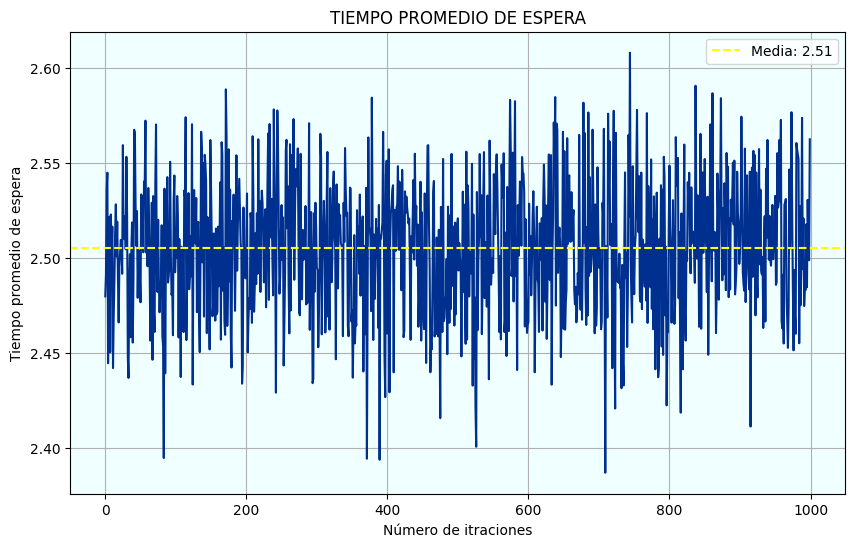

In [142]:
    plt.figure()
    plt.figure(figsize=(10, 6))
    plt.plot(mean_espera,color='#00308F')
    plt.axhline(y=np.mean(mean_espera), color='yellow', linestyle='--', label=f'Media: {np.mean(mean_espera):.2f}')
    plt.xlabel("Número de itraciones")
    plt.ylabel("Tiempo promedio de espera")
    plt.title("TIEMPO PROMEDIO DE ESPERA")
    plt.grid(True)
    plt.gca().set_facecolor('#F0FFFF')
    plt.legend()
    plt.show()

**INTERVALO DE CONFIANZA**

In [143]:
confidence_interval = st.t.interval(0.95, len(mean_espera) - 1, loc=np.mean(mean_espera), scale=st.sem(mean_espera))
print(f"Intervalo de confianza del 95%: {confidence_interval}")

Intervalo de confianza del 95%: (2.503109155684843, 2.5074968017137067)


El tiempo promedio de espera no sigue ninguna tendencia, según el intervalo de confianza esta entere (2.503,2.507). Es importante disminuir este tiempo de espera para evitar conglomeraciones dentro de la estación del metrobús.